## Data Preperation for Poisson Regression Model

### Loading

In [ ]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime,timedelta
import pandas.api.types as ptypes

import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from IPython.display import display

from statsmodels.stats.stattools import jarque_bera
from statsmodels.stats.diagnostic import het_breuschpagan

In [ ]:
status_final = pd.read_csv(r"C:\Users\etaiw\Desktop\Projects\aviya_project\Data\Clean Data\Assign to Parking Lots Data\merged_parking_data_2023_2025.csv")
weather_original = pd.read_csv(r"C:\Users\etaiw\Desktop\Projects\aviya_project\Data\Clean Data\Final Weather\merged_weather_data_2023_2025.csv")

trips = status_final
weather = weather_original

In [ ]:
print("STEP 0 - DataFrames loaded:")
print("trips shape:", trips.shape)
print("weather shape:", weather.shape)

STEP 0 - DataFrames loaded:
trips shape: (6334, 12)
weather shape: (1393, 7)


### STEP 1 - Prepare trips data at hourly resolution

In [ ]:
# =========================================================
# STEP 1 - Prepare trips data at hourly resolution
# =========================================================

# 1.1 Ensure start_time is datetime
trips['start_time'] = pd.to_datetime(trips['start_time'], errors='coerce')

# 1.2 Keep only trip_start events (if the column exists)
if 'event_types' in trips.columns:
    trips_start_hr = trips[trips['event_types'] == 'trip_start'].copy()
else:
    trips_start_hr = trips.copy()

# 1.3 Floor to hour → this will be the time key for merging with weather
trips_start_hr['datetime_hour'] = trips_start_hr['start_time'].dt.floor('H')
trips_start_hr['date'] = trips_start_hr['datetime_hour'].dt.date
trips_start_hr['hour'] = trips_start_hr['datetime_hour'].dt.hour  # 0..23

print("\nSTEP 1 - trips_start_hr with datetime_hour/date/hour (sample):")
display(trips_start_hr[['start_time', 'datetime_hour', 'date', 'hour']].head())


STEP 1 - trips_start_hr with datetime_hour/date/hour (sample):


C:\Users\etaiw\AppData\Local\Temp\ipykernel_17856\3045977678.py:15: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  trips_start_hr['datetime_hour'] = trips_start_hr['start_time'].dt.floor('H')


,start_time,datetime_hour,date,hour
1,2024-02-02 03:34:13,2024-02-02 03:00:00,2024-02-02,3
5,2024-02-13 19:53:39,2024-02-13 19:00:00,2024-02-13,19
7,2024-02-01 16:14:52,2024-02-01 16:00:00,2024-02-01,16
9,2024-02-12 14:01:11,2024-02-12 14:00:00,2024-02-12,14
11,2024-02-21 17:27:17,2024-02-21 17:00:00,2024-02-21,17


### STEP 2 - Aggregate trips to trips_per_hour (target y)

In [ ]:
# =========================================================
# STEP 2A - Prepare hourly weather from raw weather_original
# =========================================================

# Start from the original clean weather dataframe
weather = weather_original.copy()

# Make sure 'datetime' is really datetime dtype
weather['datetime'] = pd.to_datetime(weather['datetime'], errors='coerce')

# Floor to hour resolution
weather['datetime_hour'] = weather['datetime'].dt.floor('H')

# Aggregate to hourly weather
hourly_weather = (
    weather
      .groupby('datetime_hour')
      .agg(
          temp_c      = ('temp_c', 'mean'),
          temp_max_c  = ('temp_max_c', 'mean'),
          temp_min_c  = ('temp_min_c', 'mean'),
          wind_speed_ms = ('wind_speed_ms', 'mean'),
          rain_mm     = ('rain_mm', 'sum'),
      )
      .reset_index()
)

print("\nSTEP 2A - hourly_weather (first rows):")
display(hourly_weather.head())
print("\nSTEP 2A - hourly_weather shape:", hourly_weather.shape)



STEP 2A - hourly_weather (first rows):


C:\Users\etaiw\AppData\Local\Temp\ipykernel_17856\2694457965.py:12: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  weather['datetime_hour'] = weather['datetime'].dt.floor('H')


,datetime_hour,temp_c,temp_max_c,temp_min_c,wind_speed_ms,rain_mm
0,2024-02-01 00:00:00,9.916667,10.00,9.85,2.70,0.0
1,2024-02-01 01:00:00,9.566667,9.75,9.45,2.75,0.0
2,2024-02-01 02:00:00,9.266667,9.40,9.15,2.80,0.0
3,2024-02-01 03:00:00,10.583333,11.40,9.35,5.10,0.0
4,2024-02-01 04:00:00,12.766667,13.00,12.55,7.30,0.0



STEP 2A - hourly_weather shape: (697, 6)


In [ ]:
# =========================================================
# STEP 2B - Aggregate trips to trips_per_hour (target y)
# =========================================================

hourly_trips = (
    trips_start_hr
    .groupby('datetime_hour')
    .size()
    .rename('trips_per_hour')
    .reset_index()
)

print("\nSTEP 2B - hourly_trips (first rows):")
display(hourly_trips.head())

print("\nSTEP 2B - hourly_trips shape:", hourly_trips.shape)
print("\nSTEP 2B - trips_per_hour summary:")
display(hourly_trips['trips_per_hour'].describe().to_frame(name='trips_per_hour_stats'))



STEP 2B - hourly_trips (first rows):


,datetime_hour,trips_per_hour
0,2024-02-01 00:00:00,2
1,2024-02-01 01:00:00,1
2,2024-02-01 06:00:00,1
3,2024-02-01 09:00:00,4
4,2024-02-01 10:00:00,3



STEP 2B - hourly_trips shape: (526, 2)

STEP 2B - trips_per_hour summary:


,trips_per_hour_stats
count,526.000000
mean,5.553232
std,4.754549
min,1.000000
25%,2.000000
50%,4.000000
75%,8.000000
max,23.000000


### STEP 3 - Build full hourly panel and merge trips (with interpolation time based)
Interpolation = fills missing or intermediate values by estimating them from surrounding data points

In [ ]:
# =========================================================
# STEP 3 - Build full hourly panel and merge trips (with interpolation)
# =========================================================

from IPython.display import display

# 3.1 Define full hourly range based on weather datetime_hour
start_hour = weather['datetime_hour'].min().floor('H')
end_hour   = weather['datetime_hour'].max().ceil('H')

full_hours = pd.date_range(start=start_hour, end=end_hour, freq='H')
reg_hourly = pd.DataFrame({'datetime_hour': full_hours})

print("\nSTEP 3 - full_hours created:")
print(reg_hourly.shape)
display(reg_hourly.head(10))

# 3.2 Merge hourly trips (NaN → 0 trips)
reg_hourly = reg_hourly.merge(hourly_trips, on='datetime_hour', how='left')
reg_hourly['trips_per_hour'] = reg_hourly['trips_per_hour'].fillna(0).astype(int)

# 3.3 Merge hourly weather (NaNs to be interpolated)
reg_hourly = reg_hourly.merge(hourly_weather, on='datetime_hour', how='left')

print("\nSTEP 3 - before interpolation (check NaNs):")
display(reg_hourly.isna().sum().to_frame('n_missing'))

# 3.4 Interpolate missing weather columns over time
reg_hourly = reg_hourly.sort_values('datetime_hour').set_index('datetime_hour')
weather_cols = ['temp_c', 'temp_max_c', 'temp_min_c', 'wind_speed_ms', 'rain_mm']

reg_hourly[weather_cols] = reg_hourly[weather_cols].interpolate(
    method='time',
    limit_direction='both'
)

# 3.5 Back to normal index and sanity check for hourly gaps
reg_hourly = reg_hourly.reset_index()

print("\nSTEP 3 - after interpolation (check gaps):")
reg_hourly['delta'] = reg_hourly['datetime_hour'].diff().dt.total_seconds() / 3600
print(reg_hourly['delta'].value_counts().head(10))

print("\nSTEP 3 - Sample of datetime_hour + trips_per_hour:")
display(reg_hourly[['datetime_hour', 'trips_per_hour']].head(24))



STEP 3 - full_hours created:
(697, 1)


C:\Users\etaiw\AppData\Local\Temp\ipykernel_17856\2466237866.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_hour = weather['datetime_hour'].min().floor('H')
C:\Users\etaiw\AppData\Local\Temp\ipykernel_17856\2466237866.py:9: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  end_hour   = weather['datetime_hour'].max().ceil('H')
C:\Users\etaiw\AppData\Local\Temp\ipykernel_17856\2466237866.py:11: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_hours = pd.date_range(start=start_hour, end=end_hour, freq='H')


,datetime_hour
0,2024-02-01 00:00:00
1,2024-02-01 01:00:00
2,2024-02-01 02:00:00
3,2024-02-01 03:00:00
4,2024-02-01 04:00:00
5,2024-02-01 05:00:00
6,2024-02-01 06:00:00
7,2024-02-01 07:00:00
8,2024-02-01 08:00:00
9,2024-02-01 09:00:00



STEP 3 - before interpolation (check NaNs):


,n_missing
datetime_hour,0
trips_per_hour,0
temp_c,0
temp_max_c,0
temp_min_c,0
wind_speed_ms,0
rain_mm,0



STEP 3 - after interpolation (check gaps):
delta
1.0    696
Name: count, dtype: int64

STEP 3 - Sample of datetime_hour + trips_per_hour:


,datetime_hour,trips_per_hour
0,2024-02-01 00:00:00,2
1,2024-02-01 01:00:00,1
2,2024-02-01 02:00:00,0
3,2024-02-01 03:00:00,0
4,2024-02-01 04:00:00,0
5,2024-02-01 05:00:00,0
6,2024-02-01 06:00:00,1
7,2024-02-01 07:00:00,0
8,2024-02-01 08:00:00,0
9,2024-02-01 09:00:00,4


### STEP 4 - Add weekday (int), weekday_name, weekend (0/1)

In [ ]:
# =========================================================
# STEP 4 - Add weekday (Sunday=0), weekend, weekday_name
# =========================================================

# Python weekday: Monday=0, Sunday=6
python_weekday_hr = reg_hourly['datetime_hour'].dt.weekday

# Custom weekday: Sunday=0, Monday=1, ..., Saturday=6
reg_hourly['weekday'] = (python_weekday_hr + 1) % 7

# Weekend in Israel: Friday (5) and Saturday (6) in this coding
reg_hourly['is_weekend'] = reg_hourly['weekday'].isin([5, 6]).astype(int)

# Human-readable weekday name
reg_hourly['weekday_name'] = reg_hourly['datetime_hour'].dt.day_name()

print("\nSTEP 4 - weekday (Sunday=0), is_weekend, weekday_name (sample):")
display(reg_hourly[['datetime_hour', 'weekday', 'weekday_name', 'is_weekend']].head())



STEP 4 - weekday (Sunday=0), is_weekend, weekday_name (sample):


,datetime_hour,weekday,weekday_name,is_weekend
0,2024-02-01 00:00:00,4,Thursday,0
1,2024-02-01 01:00:00,4,Thursday,0
2,2024-02-01 02:00:00,4,Thursday,0
3,2024-02-01 03:00:00,4,Thursday,0
4,2024-02-01 04:00:00,4,Thursday,0


### STEP 5 - Define flexible time-of-day segments
#### Update HERE for different time slots

In [ ]:
# =========================================================
# STEP 5 - Create time-of-day segments and dummies
# =========================================================

from IPython.display import display

# 5.0 Make sure 'hour' column exists
if 'hour' not in reg_hourly.columns:
    reg_hourly['hour'] = reg_hourly['datetime_hour'].dt.hour

print("STEP 5 - Hour column check:")
print(reg_hourly[['datetime_hour', 'hour']].head())

# 5.1 Remove old TOD columns if they exist
cols_to_drop = [c for c in reg_hourly.columns if c.startswith('tod_')] + ['tod_segment']
if cols_to_drop:
    reg_hourly = reg_hourly.drop(columns=cols_to_drop, errors='ignore')

# 5.2 Define logical time-of-day mapping
# Night is one continuous logical category: 20:00–24:00 AND 00:00–07:00
def map_tod(hour):
    # night: 20:00–24:00 or 00:00–07:00
    if (hour >= 20) or (hour < 7):
        return 'night'
    # morning: 07:00–10:00
    elif 7 <= hour < 10:
        return 'morning'
    # afternoon (day): 10:00–16:00
    elif 10 <= hour < 16:
        return 'afternoon'
    # evening: 16:00–20:00
    else:  # 16 <= hour < 20
        return 'evening'

reg_hourly['tod_segment'] = reg_hourly['hour'].apply(map_tod)

# 5.3 Ensure categorical type with explicit order so that
# 'night' is the baseline when we create dummies (drop_first=True)
tod_cat_type = pd.api.types.CategoricalDtype(
    categories=['night', 'morning', 'afternoon', 'evening'],
    ordered=True
)
reg_hourly['tod_segment'] = reg_hourly['tod_segment'].astype(tod_cat_type)

print("\nSTEP 5 - tod_segment created (night = 20:00–07:00):")
display(reg_hourly[['datetime_hour', 'hour', 'tod_segment']].head())


STEP 5 - Hour column check:
        datetime_hour  hour
0 2024-02-01 00:00:00     0
1 2024-02-01 01:00:00     1
2 2024-02-01 02:00:00     2
3 2024-02-01 03:00:00     3
4 2024-02-01 04:00:00     4

STEP 5 - tod_segment created (night = 20:00–07:00):


,datetime_hour,hour,tod_segment
0,2024-02-01 00:00:00,0,night
1,2024-02-01 01:00:00,1,night
2,2024-02-01 02:00:00,2,night
3,2024-02-01 03:00:00,3,night
4,2024-02-01 04:00:00,4,night


### STEP 6 - Create dummy variables for weekday and TOD segments

#### 6.0 - Create weekday dummy variables

In [ ]:
# =========================================================
# STEP 6.0 - Choose subset for modeling and create weekday dummies
# =========================================================
# weekday coding in this notebook: Sunday=0 ... Saturday=6

MODE_FOR_MAIN_MODEL = "weekdays"  # options: "all", "weekdays", "weekends"

def subset_by_mode(df, mode):
    if mode == "all":
        return df.copy()
    if mode == "weekdays":
        return df[df["weekday"].isin([0, 1, 2, 3, 4])].copy()   # Sun–Thu
    if mode == "weekends":
        return df[df["weekday"].isin([5, 6])].copy()           # Fri–Sat
    raise ValueError("mode must be one of: all, weekdays, weekends")

reg_model = subset_by_mode(reg_hourly, MODE_FOR_MAIN_MODEL).copy()
reg_model["hour"] = reg_model["datetime_hour"].dt.hour

# Keep reg_wd as an alias so downstream cells that expect reg_wd won't break
reg_wd = reg_model

# Weekday dummies (Sunday baseline via drop_first)
wd_dummy_cols = pd.get_dummies(reg_model["weekday"], prefix="wd", drop_first=True)

print("MODE_FOR_MAIN_MODEL:", MODE_FOR_MAIN_MODEL)
print("reg_model shape:", reg_model.shape)
print("wd_dummy_cols shape:", wd_dummy_cols.shape)
display(wd_dummy_cols.head())


MODE_FOR_MAIN_MODEL: weekdays
reg_model shape: (504, 13)
wd_dummy_cols shape: (504, 4)


,wd_1,wd_2,wd_3,wd_4
0,False,False,False,True
1,False,False,False,True
2,False,False,False,True
3,False,False,False,True
4,False,False,False,True


#### 6.1 - Create TOD (Time Of Day Segment) dummy variables

In [ ]:
# =========================================================
# STEP 6.1 - Create TOD (Time Of Day Segment) dummy variables (BASELINE)
# =========================================================
# 4-bin TOD scheme (edit cutoffs if you used different ones in your thesis)
reg_model["tod_segment"] = pd.cut(
    reg_model["hour"],
    bins=[-1, 5, 11, 17, 23],
    labels=["night", "morning", "afternoon", "evening"]
)

tod_dummy_cols = pd.get_dummies(reg_model["tod_segment"], prefix="tod", drop_first=True)

print("TOD dummy columns created:", tod_dummy_cols.columns.tolist())
print("tod_dummy_cols shape:", tod_dummy_cols.shape)
display(tod_dummy_cols.head())


TOD dummy columns created: ['tod_morning', 'tod_afternoon', 'tod_evening']
tod_dummy_cols shape: (504, 3)


,tod_morning,tod_afternoon,tod_evening
0,False,False,False
1,False,False,False
2,False,False,False
3,False,False,False
4,False,False,False


#### 6.2 - Build feature list (X&Y)

In [ ]:
# =========================================================
# STEP 6.2 - Build feature matrices (X) and target (y)
# =========================================================

# Choose weather columns that exist in your panel
weather_cols = [c for c in ["temp_c", "rain_mm", "wind_speed_ms"] if c in reg_model.columns]
print("Weather columns used:", weather_cols)

y_hr = reg_model["trips_per_hour"]

# Baseline X: TOD + weekday + weather
X_baseline = pd.concat([tod_dummy_cols, wd_dummy_cols, reg_model[weather_cols]], axis=1)
X_baseline = sm.add_constant(X_baseline, has_constant="add")

# Optimized X: Hour fixed effects + weekday + weather
hour_dummy_cols = pd.get_dummies(reg_model["hour"], prefix="hour", drop_first=True)
X_hourFE = pd.concat([hour_dummy_cols, wd_dummy_cols, reg_model[weather_cols]], axis=1)
X_hourFE = sm.add_constant(X_hourFE, has_constant="add")

print("X_baseline shape:", X_baseline.shape)
print("X_hourFE shape:", X_hourFE.shape)
print("y_hr shape:", y_hr.shape)


Weather columns used: ['temp_c', 'rain_mm', 'wind_speed_ms']
X_baseline shape: (504, 11)
X_hourFE shape: (504, 31)
y_hr shape: (504,)


#### 6.3 - FIX v2: Clean features (drop non-numeric / all-NaN columns)

In [ ]:
# =========================================================
# STEP 6.3 - Clean features (force numeric, fill NaNs)
# =========================================================

def clean_X(X: pd.DataFrame) -> pd.DataFrame:
    Xc = X.copy()
    Xc = Xc.apply(pd.to_numeric, errors="coerce")
    Xc = Xc.fillna(0)
    return Xc.astype(float)

X_baseline_clean = clean_X(X_baseline)
X_hourFE_clean   = clean_X(X_hourFE)

# Keep names used later in the notebook
X_hr = X_hourFE_clean

print("Cleaned shapes:")
print("X_baseline_clean:", X_baseline_clean.shape)
print("X_hourFE_clean:", X_hourFE_clean.shape)
display(X_hourFE_clean.head())


Cleaned shapes:
X_baseline_clean: (504, 11)
X_hourFE_clean: (504, 31)


,const,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,...,hour_21,hour_22,hour_23,wd_1,wd_2,wd_3,wd_4,temp_c,rain_mm,wind_speed_ms
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,9.916667,0.0,2.70
1,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,9.566667,0.0,2.75
2,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,9.266667,0.0,2.80
3,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,10.583333,0.0,5.10
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,12.766667,0.0,7.30


## Poisson Models

#### STEP 7 - Fit Poisson models (Baseline vs Hour-FE) + diagnostics


In [ ]:
# =========================================================
# STEP 7 - Fit Poisson models (Baseline vs Hour-FE) + diagnostics
# =========================================================

# Baseline Poisson (TOD)
poisson_baseline = sm.GLM(y_hr, X_baseline_clean, family=sm.families.Poisson()).fit()
disp_baseline = (poisson_baseline.resid_pearson**2).sum() / poisson_baseline.df_resid

print("BASELINE (TOD) Poisson")
print(poisson_baseline.summary().tables[0])
print(f"Dispersion (Pearson Chi2 / df_resid): {disp_baseline:.3f}")

# Optimized Poisson (Hour fixed effects)
poisson_hr_results = sm.GLM(y_hr, X_hourFE_clean, family=sm.families.Poisson()).fit()
disp_hourFE = (poisson_hr_results.resid_pearson**2).sum() / poisson_hr_results.df_resid

print("\nOPTIMIZED (Hour-FE) Poisson")
print(poisson_hr_results.summary().tables[0])
print(f"Dispersion (Pearson Chi2 / df_resid): {disp_hourFE:.3f}")

# Robust SE for optimized model (same coefficients, safer inference)
poisson_hr_results_robust = sm.GLM(y_hr, X_hourFE_clean, family=sm.families.Poisson()).fit(cov_type="HC0")
print("\nOPTIMIZED (Hour-FE) Poisson with Robust SE (HC0)")
print(poisson_hr_results_robust.summary().tables[0])

# Keep a single reference used later
dispersion_main = disp_hourFE


BASELINE (TOD) Poisson
                 Generalized Linear Model Regression Results                  
Dep. Variable:         trips_per_hour   No. Observations:                  504
Model:                            GLM   Df Residuals:                      493
Model Family:                 Poisson   Df Model:                           10
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1241.7
Date:                Sun, 28 Dec 2025   Deviance:                       1150.2
Time:                        17:21:16   Pearson chi2:                 1.19e+03
No. Iterations:                     6   Pseudo R-squ. (CS):             0.9589
Covariance Type:            nonrobust                                         
Dispersion (Pearson Chi2 / df_resid): 2.421

OPTIMIZED (Hour-FE) Poisson
                 Generalized Linear Model Regression Results                  
Dep. Variable:         trips_per_ho

#### STEP 7b - 3-way comparison (All vs Weekdays vs Weekends) using Optimized Poisson


In [ ]:
# =========================================================
# STEP 7b - 3-way comparison (All vs Weekdays vs Weekends) using Optimized Poisson
# =========================================================

modes = ["all", "weekdays", "weekends"]
results = {}

for mode in modes:
    dfm = subset_by_mode(reg_hourly, mode).copy()
    dfm["hour"] = dfm["datetime_hour"].dt.hour

    hour_dummies = pd.get_dummies(dfm["hour"], prefix="hour", drop_first=True)
    wd_dummies   = pd.get_dummies(dfm["weekday"], prefix="wd", drop_first=True)
    weather_cols = [c for c in ["temp_c", "rain_mm", "wind_speed_ms"] if c in dfm.columns]

    X = pd.concat([hour_dummies, wd_dummies, dfm[weather_cols]], axis=1)
    X = sm.add_constant(X, has_constant="add")
    X = clean_X(X)
    y = dfm["trips_per_hour"]

    res = sm.GLM(y, X, family=sm.families.Poisson()).fit(cov_type="HC0")
    disp = (res.resid_pearson**2).sum() / res.df_resid

    results[mode] = {"n": len(dfm), "dispersion": float(disp), "res": res}

summary_df = pd.DataFrame({m: {"n": results[m]["n"], "dispersion": results[m]["dispersion"]} for m in modes}).T
summary_df


,n,dispersion
all,697.0,2.377682
weekdays,504.0,1.428184
weekends,193.0,1.631155


# STEP 8 — Model Diagnostics & Visualization (Poisson)

#### STEP 8.0 — Setup helpers (paste as one cell)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats

# --- safety checks ---
required_cols = ["datetime_hour", "trips_per_hour", "weekday"]
for c in required_cols:
    if c not in reg_hourly.columns:
        raise KeyError(f"reg_hourly is missing column: {c}")

def subset_by_mode(df, mode):
    """
    mode options:
      - "all": Sun–Sat
      - "weekdays": Sun–Thu (weekday in {0,1,2,3,4} where Sunday=0)
      - "weekends": Fri–Sat (weekday in {5,6})
    """
    if mode == "all":
        return df.copy()
    if mode == "weekdays":
        return df[df["weekday"].isin([0,1,2,3,4])].copy()
    if mode == "weekends":
        return df[df["weekday"].isin([5,6])].copy()
    raise ValueError("mode must be one of: all, weekdays, weekends")

def clean_X(X: pd.DataFrame) -> pd.DataFrame:
    return X.apply(pd.to_numeric, errors="coerce").fillna(0).astype(float)

def build_hourFE_design(dfm: pd.DataFrame):
    """
    Builds the same X used in the optimized Poisson:
    hour fixed effects + weekday dummies + weather.
    Returns (X, y, dfm_with_hour)
    """
    dfm = dfm.copy()
    dfm["hour"] = dfm["datetime_hour"].dt.hour

    hour_dummies = pd.get_dummies(dfm["hour"], prefix="hour", drop_first=True)
    wd_dummies   = pd.get_dummies(dfm["weekday"], prefix="wd", drop_first=True)

    weather_cols = [c for c in ["temp_c", "rain_mm", "wind_speed_ms"] if c in dfm.columns]

    X = pd.concat([hour_dummies, wd_dummies, dfm[weather_cols]], axis=1)
    X = sm.add_constant(X, has_constant="add")
    X = clean_X(X)

    y = dfm["trips_per_hour"].astype(int)
    return X, y, dfm

def fit_poisson_hourFE(dfm: pd.DataFrame, robust=True):
    X, y, dfm2 = build_hourFE_design(dfm)
    if robust:
        res = sm.GLM(y, X, family=sm.families.Poisson()).fit(cov_type="HC0")
    else:
        res = sm.GLM(y, X, family=sm.families.Poisson()).fit()
    return res, X, y, dfm2

def dispersion(res):
    pearson_chi2 = float(np.sum(res.resid_pearson ** 2))
    return pearson_chi2 / float(res.df_resid)

# Choose what you want to visualize here:
STEP8_MODE = "weekdays"   # "all" / "weekdays" / "weekends"

df_plot = subset_by_mode(reg_hourly, STEP8_MODE)
res_plot, X_plot, y_plot, df_plot = fit_poisson_hourFE(df_plot, robust=True)

print("STEP8_MODE:", STEP8_MODE)
print("n:", len(df_plot), "| dispersion:", round(dispersion(res_plot), 3))


STEP8_MODE: weekdays
n: 504 | dispersion: 1.428


#### STEP 8.1 — Observed vs Fitted (scatter)

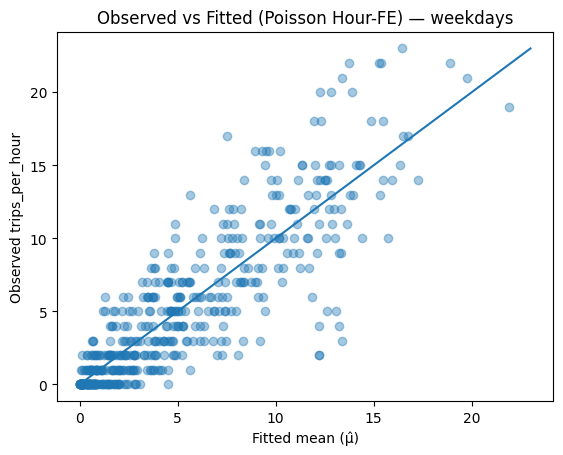

In [ ]:
mu_hat = res_plot.fittedvalues  # predicted mean (Poisson)
y_obs = y_plot.values

plt.figure()
plt.scatter(mu_hat, y_obs, alpha=0.4)
plt.xlabel("Fitted mean (μ̂)")
plt.ylabel("Observed trips_per_hour")
plt.title(f"Observed vs Fitted (Poisson Hour-FE) — {STEP8_MODE}")

# 45-degree reference line
mx = max(mu_hat.max(), y_obs.max())
plt.plot([0, mx], [0, mx])
plt.show()


#### STEP 8.2 — Pearson residuals vs fitted

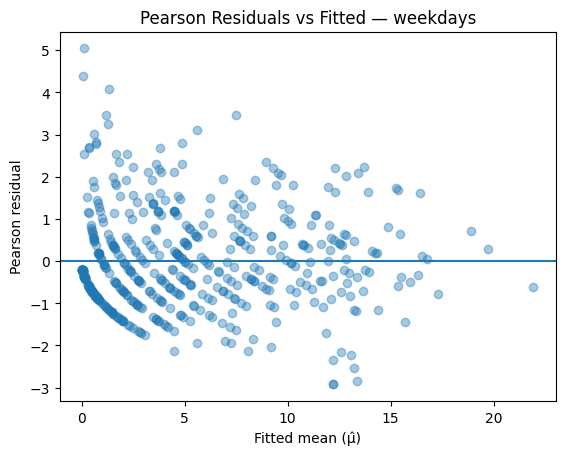

In [ ]:
mu_hat = res_plot.fittedvalues
pearson_resid = res_plot.resid_pearson

plt.figure()
plt.scatter(mu_hat, pearson_resid, alpha=0.4)
plt.axhline(0)
plt.xlabel("Fitted mean (μ̂)")
plt.ylabel("Pearson residual")
plt.title(f"Pearson Residuals vs Fitted — {STEP8_MODE}")
plt.show()


#### STEP 8.4 — Compare distributions: Weekdays vs Weekends (hist + ECDF + KS test)

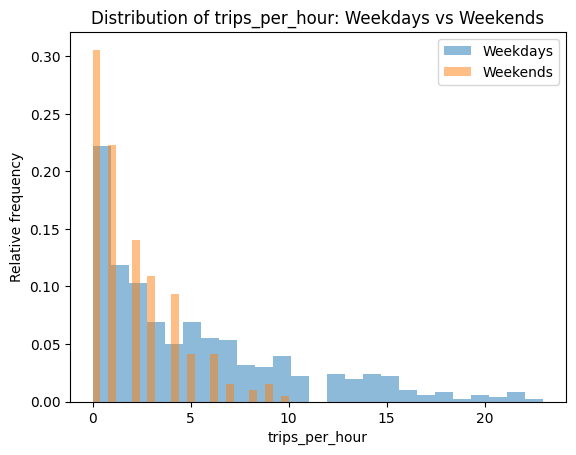

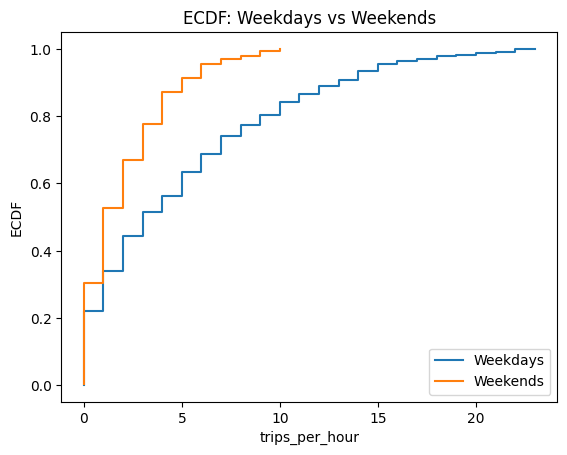

KS test Weekdays vs Weekends:
  statistic: 0.3069742577514598
  p-value: 3.848608437797846e-12


In [ ]:
df_wd = subset_by_mode(reg_hourly, "weekdays").copy()
df_we = subset_by_mode(reg_hourly, "weekends").copy()

y_wd = df_wd["trips_per_hour"].values
y_we = df_we["trips_per_hour"].values

# Histogram (density-ish via weights)
plt.figure()
plt.hist(y_wd, bins=25, alpha=0.5, weights=np.ones_like(y_wd)/len(y_wd), label="Weekdays")
plt.hist(y_we, bins=25, alpha=0.5, weights=np.ones_like(y_we)/len(y_we), label="Weekends")
plt.xlabel("trips_per_hour")
plt.ylabel("Relative frequency")
plt.title("Distribution of trips_per_hour: Weekdays vs Weekends")
plt.legend()
plt.show()

# ECDF
def ecdf(a):
    a = np.sort(a)
    y = np.arange(1, len(a)+1) / len(a)
    return a, y

x1, y1 = ecdf(y_wd)
x2, y2 = ecdf(y_we)

plt.figure()
plt.step(x1, y1, where="post", label="Weekdays")
plt.step(x2, y2, where="post", label="Weekends")
plt.xlabel("trips_per_hour")
plt.ylabel("ECDF")
plt.title("ECDF: Weekdays vs Weekends")
plt.legend()
plt.show()

# KS test
ks = stats.ks_2samp(y_wd, y_we, alternative="two-sided", mode="auto")
print("KS test Weekdays vs Weekends:")
print("  statistic:", ks.statistic)
print("  p-value:", ks.pvalue)



#### STEP 8.5 — “Active hours” diagnostic (fixes your hour_true KeyError) overdispersion checking

Active-hours sample size: 231
Zero rate in active hours (%): 0.0
Active-hours dispersion: 1.387


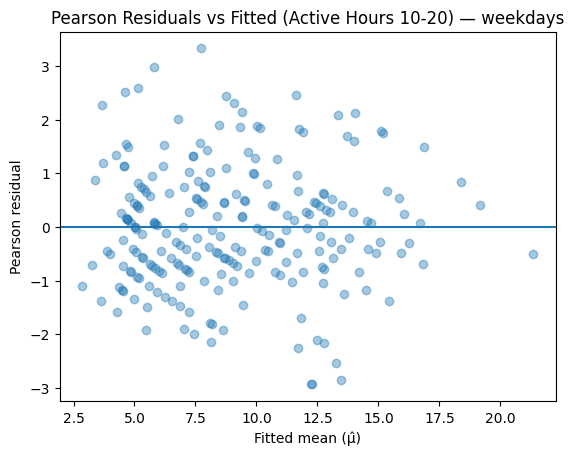

In [ ]:
df_active = df_plot.copy()
df_active["hour"] = df_active["datetime_hour"].dt.hour

ACTIVE_START = 10
ACTIVE_END = 20

reg_active = df_active[df_active["hour"].between(ACTIVE_START, ACTIVE_END)].copy()

print("Active-hours sample size:", reg_active.shape[0])
print("Zero rate in active hours (%):", (reg_active["trips_per_hour"] == 0).mean() * 100)

# Fit Poisson on active hours (same spec)
res_active, X_active, y_active, reg_active = fit_poisson_hourFE(reg_active, robust=True)
print("Active-hours dispersion:", round(dispersion(res_active), 3))

# Plot residuals vs fitted in active hours
mu_hat = res_active.fittedvalues
pearson_resid = res_active.resid_pearson

plt.figure()
plt.scatter(mu_hat, pearson_resid, alpha=0.4)
plt.axhline(0)
plt.xlabel("Fitted mean (μ̂)")
plt.ylabel("Pearson residual")
plt.title(f"Pearson Residuals vs Fitted (Active Hours {ACTIVE_START}-{ACTIVE_END}) — {STEP8_MODE}")
plt.show()


#### STEP 8.6 – KS test: Friday vs Saturday

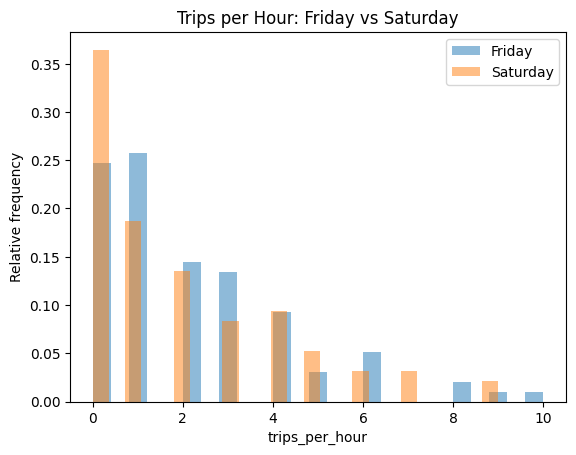

KS test Friday vs Saturday
Statistic: 0.1171606529209622
p-value: 0.4794583132368663


In [ ]:
# =========================================================
# STEP 8.6 – KS test: Friday vs Saturday
# =========================================================

df_fri = reg_hourly[reg_hourly["weekday"] == 5]["trips_per_hour"].values
df_sat = reg_hourly[reg_hourly["weekday"] == 6]["trips_per_hour"].values

# Histograms
plt.figure()
plt.hist(df_fri, bins=25, alpha=0.5, weights=np.ones_like(df_fri)/len(df_fri), label="Friday")
plt.hist(df_sat, bins=25, alpha=0.5, weights=np.ones_like(df_sat)/len(df_sat), label="Saturday")
plt.xlabel("trips_per_hour")
plt.ylabel("Relative frequency")
plt.title("Trips per Hour: Friday vs Saturday")
plt.legend()
plt.show()

# KS test
ks_fs = stats.ks_2samp(df_fri, df_sat)
print("KS test Friday vs Saturday")
print("Statistic:", ks_fs.statistic)
print("p-value:", ks_fs.pvalue)
